## Problem 3

#### Import Libraries

In [1]:
import torch
import pandas as pd
from sklearn import datasets
import seaborn as sns
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, TensorDataset
import torch.nn.functional as F

#### Import Dataset

In [2]:
from google.colab import files
files.upload()
dataset = pd.read_csv("iris.csv")

dataset

Saving iris.csv to iris.csv


,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


#### Dataset Pre-processing

In [3]:
dataset['variety'].value_counts()

Setosa        50
Versicolor    50
Virginica     50
Name: variety, dtype: int64

In [4]:
variety = list(dataset["variety"].unique())
dataset["species_index"] = dataset["variety"].apply(variety.index)
dataset.head()

,sepal.length,sepal.width,petal.length,petal.width,variety,species_index
0,5.1,3.5,1.4,0.2,Setosa,0
1,4.9,3.0,1.4,0.2,Setosa,0
2,4.7,3.2,1.3,0.2,Setosa,0
3,4.6,3.1,1.5,0.2,Setosa,0
4,5.0,3.6,1.4,0.2,Setosa,0


#### Data Visualization

In [5]:
import plotly
import plotly.express as px

fig = px.scatter_3d(dataset[["sepal.length","sepal.width","petal.length","petal.width","variety"]],
                    x = 'sepal.length',
                    y = 'sepal.width',
                    z = 'petal.width',
                    size = 'petal.length',
                    color = 'variety',
                    opacity = 0.7)

fig.update_layout(margin = dict(l=0, r=0, b=0, t=0))

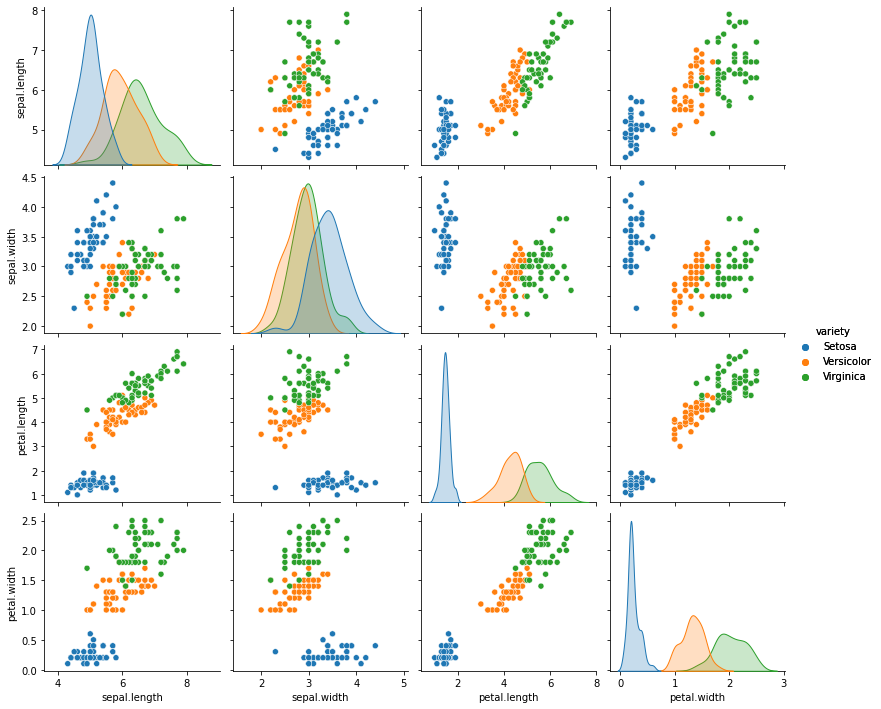

In [6]:
sns.pairplot(dataset[["sepal.length","sepal.width","petal.length","petal.width","variety"]], hue = "variety") \
.add_legend();

#### Preparing Data for Training

In [7]:
input_columns_all = torch.from_numpy(dataset[list(dataset.columns)[:-2]].to_numpy()).type(torch.float32)
input_columns = torch.from_numpy(dataset[['petal.length', 'petal.width']].to_numpy()).type(torch.float32)
output_columns = torch.tensor(dataset['species_index'])

print("Input columns all: ", input_columns_all.shape, input_columns_all.dtype)
print("Input columns: ", input_columns.shape, input_columns.dtype)
print("Output columns: ", output_columns.shape, output_columns.dtype)

Input columns all:  torch.Size([150, 4]) torch.float32
Input columns:  torch.Size([150, 2]) torch.float32
Output columns:  torch.Size([150]) torch.int64


In [8]:
data = TensorDataset(input_columns, output_columns)

In [11]:
split = 0.1
rows = list(input_columns.shape)[0]
test_split = int(rows*split)
val_split = int(rows*split*2)
train_split = rows - val_split - test_split

train_set, val_set, test_set = random_split(data, [train_split, val_split, test_split])


In [12]:
train_loader = DataLoader(train_set, 16, shuffle = True) #batch size = 16
val_loader = DataLoader(val_set) #batch size = 1
test_loader = DataLoader(test_set) #batch size = 1

In [13]:
for x in val_loader:
    print (x)
    break

[tensor([[5.1000, 2.4000]]), tensor([2])]


#### Creating the Model

In [14]:
class IrisModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 8)
        self.drop = nn.Dropout(0.1)
        self.linear2 = nn.Linear(8, output_size)

    def forward(self, x):
        x1 = self.linear1(x)
        x2 = self.drop(x1)
        outputs = self.linear2(x2)
        return outputs

    def training_step(self, batch):
        inputs, targets = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, targets)
        _, pred = torch.max(outputs, 1)
        accuracy = torch.tensor(torch.sum(pred==targets).item()/len(pred))
        return [loss.detach(), accuracy.detach()] 

In [15]:
def evaluate(model, loader):
    outputs = [model.validation_step(batch) for batch in loader]
    outputs = torch.tensor(outputs).T
    loss, accuracy = torch.mean(outputs, dim=1)
    return loss, accuracy

In [16]:
model = IrisModel(2, 3)
loss, accuracy = evaluate(model, val_loader)
"loss: ", loss.item(), "accuracy: ", accuracy.item()

('loss: ', 1.1719297170639038, 'accuracy: ', 0.30000001192092896)

In [17]:
def fit(model, train_loader, val_loader, epochs, lr, optimizer_function = torch.optim.Adam):
    history = {"loss" : [], "accuracy" : []}
    optimizer = optimizer_function(model.parameters(), lr)
    for epoch in range(epochs):
        print("Epoch ", epoch)
        #Train
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        #Validate
        for batch in val_loader:
            loss, accuracy = evaluate(model, val_loader)
        print("loss: ", loss.item(), "accuracy: ", accuracy.item(), "\n")
        history["loss"].append(loss.item())
        history["accuracy"].append(accuracy.item())
         
    return history

In [18]:
model = IrisModel(2, 3) # 2 input features and 3 output categories
history = fit(model, train_loader, val_loader, 16, 0.01)
loss, accuracy = evaluate(model, test_loader)
print("Evaluation result: Loss: ", loss.item(), " Accuracy: ", accuracy.item())

Epoch  0
loss:  1.009828805923462 accuracy:  0.2666666805744171 

Epoch  1
loss:  0.8681329488754272 accuracy:  0.5 

Epoch  2
loss:  0.8403902053833008 accuracy:  0.5333333611488342 

Epoch  3
loss:  0.8197780847549438 accuracy:  0.5333333611488342 

Epoch  4
loss:  0.7315115332603455 accuracy:  0.7666666507720947 

Epoch  5
loss:  0.7090026140213013 accuracy:  0.7666666507720947 

Epoch  6
loss:  0.6306631565093994 accuracy:  0.7666666507720947 

Epoch  7
loss:  0.546046257019043 accuracy:  0.9333333373069763 

Epoch  8
loss:  0.6235449910163879 accuracy:  0.7666666507720947 

Epoch  9
loss:  0.49619337916374207 accuracy:  0.8999999761581421 

Epoch  10
loss:  0.44786110520362854 accuracy:  0.9666666388511658 

Epoch  11
loss:  0.4603227376937866 accuracy:  0.8999999761581421 

Epoch  12
loss:  0.3869569003582001 accuracy:  1.0 

Epoch  13
loss:  0.4352789521217346 accuracy:  0.8999999761581421 

Epoch  14
loss:  0.4209640622138977 accuracy:  0.8666666746139526 

Epoch  15
loss:  0.3

In [19]:
data_all = TensorDataset(input_columns_all, output_columns)

#train_split, val_split and test_split defined earlier
train_set_all, val_set_all, test_set_all = random_split(data_all, [train_split, val_split, test_split])

train_loader_all = DataLoader(train_set_all, 16, shuffle = True)
val_loader_all = DataLoader(val_set_all)
test_loader_all = DataLoader(test_set_all)


In [20]:

model_all = IrisModel(4, 3)
history_all = fit(model_all, train_loader_all, val_loader_all, 16, 0.01)
loss , accuracy = evaluate(model_all, test_loader_all)
print("Evaluation result: Loss: ", loss.item(), " Accuracy: ", accuracy.item())

Epoch  0
loss:  1.2154388427734375 accuracy:  0.4333333373069763 

Epoch  1
loss:  0.9974501132965088 accuracy:  0.3333333432674408 

Epoch  2
loss:  0.7666594386100769 accuracy:  0.7333333492279053 

Epoch  3
loss:  0.7271910905838013 accuracy:  0.6333333253860474 

Epoch  4
loss:  0.6648589372634888 accuracy:  0.7333333492279053 

Epoch  5
loss:  0.6405044794082642 accuracy:  0.6666666865348816 

Epoch  6
loss:  0.49247491359710693 accuracy:  0.800000011920929 

Epoch  7
loss:  0.47808754444122314 accuracy:  0.8333333134651184 

Epoch  8
loss:  0.4643837511539459 accuracy:  0.7666666507720947 

Epoch  9
loss:  0.4135824739933014 accuracy:  0.8666666746139526 

Epoch  10
loss:  0.3890877962112427 accuracy:  0.8999999761581421 

Epoch  11
loss:  0.33495229482650757 accuracy:  0.8999999761581421 

Epoch  12
loss:  0.3236449062824249 accuracy:  1.0 

Epoch  13
loss:  0.3085058033466339 accuracy:  0.9666666388511658 

Epoch  14
loss:  0.3558645248413086 accuracy:  0.8666666746139526 

Epo